# Vector Database Generation

In [1]:
#!tar -xf sa_000020.tar -C sa1b

In [2]:
from utils import SA1B_Dataset

In [3]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import matplotlib.pyplot as plt
import cv2

try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

print(clip.available_models())

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14@336px", device=device)

transform = transforms.Compose([
    transforms.ToTensor(),
    #Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])
train_dataset = SA1B_Dataset(root='sa1b', transform=transform)

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [4]:
sample, target = train_dataset[0]
print(sample.shape, target.shape)

torch.Size([3, 2000, 1500]) torch.Size([60, 2000, 1500])


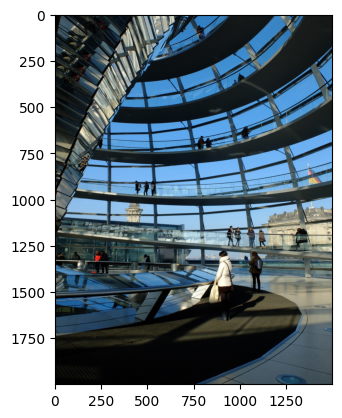

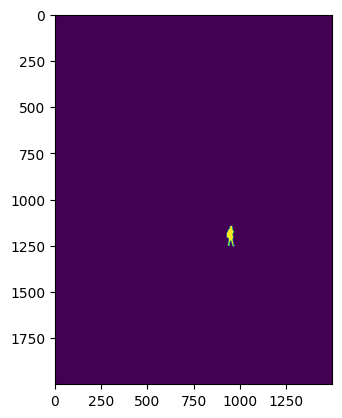

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


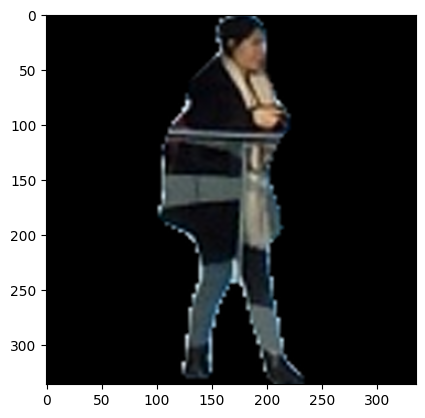

In [29]:
import torchvision.transforms.functional as F

class SquarePad:
    def __call__(self, image):
        _, h, w = image.shape
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')
    
def create_cutouts(image, masks, size):
    preprocess = Compose([
        SquarePad(),
        transforms.Resize(size, interpolation=BICUBIC),
        transforms.CenterCrop(size),
    ])
    cutouts = torch.empty((len(masks), 3, size, size))
    for i, m in enumerate(masks):
        cutout = image * m
        horizontal_indicies = torch.where(torch.any(m, dim=0))[0]
        vertical_indicies = torch.where(torch.any(m, dim=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            cropped = cutout[:, y1:(y2+1), x1:(x2+1)]
            cutouts[i] = preprocess(cropped)
            
    return cutouts

cutout_size = model.visual.input_resolution

i = 0
plt.imshow(sample.permute(1, 2, 0))
plt.show()
plt.imshow(target[i])
plt.show()
plt.imshow(create_cutouts(sample, target, cutout_size)[i].permute(1, 2, 0))

In [30]:
with torch.no_grad():
    for image, masks in train_dataset:
        cutouts = create_cutouts(image, masks, model.visual.input_resolution)
        cutouts.to(device)
        cutout_embeddings = model.encode_image(cutouts)
        print(cutout_embeddings.shape)
        
        #X.append(image)
        #Y.append(masks)
        #Z.append(cutout_embeddings)
        break

torch.Size([60, 768])


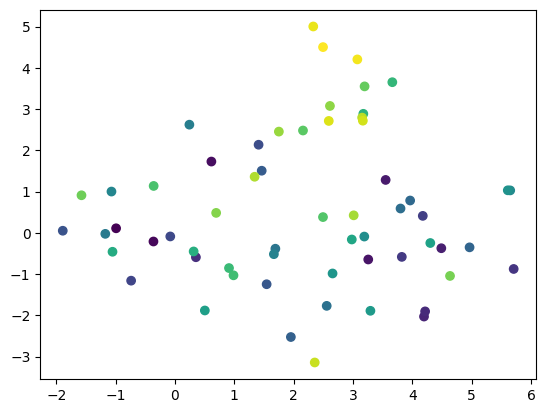

In [36]:
from sklearn.manifold import TSNE
n_components = 2
tsne = TSNE(n_components)
transformed = tsne.fit_transform(cutout_embeddings)

plt.scatter(transformed[:,0], transformed[:,1], c=range(len(cutout_embeddings)))

In [ ]:
# https://arxiv.org/pdf/2304.07193.pdf
# https://www.facebook.com/groups/faissusers/posts/1025663204524632/

#import faiss
#import faiss.contrib.torch_utils

#res = faiss.StandardGpuResources()
#index = faiss.GpuIndexIVFFlat(res, dims=128, nlist=1000, faiss.METRIC_L2)

#index.train(train_vecs)
#add_vecs = torch.rand(1000000, dims, device=torch.device('cuda', 0))
#index.add(add_vecs)

#query_vecs = torch.rand(5, dims, device=torch.device('cuda', 0))
#distances, indices = index.search(query_vecs, 5)
#print(distances)
#print(indices)